# Amazon fine food review data analysis
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset contain Amazon food review from Oct 1999 - Oct 2012 for nearly 75k products.

### This dataset contains following columns :
  1. Id
  2. ProductId - unique identifier for the product
  3. UserId - uniqiue identifier for the user
  4. ProfileName
  5. HelpfulnessNumerator - number of users who found the review helpful
  6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
  7. Score - rating between 1 and 5
  8. Time - timestamp for the review
  9. Summary - brief summary of the review
  10. Text - text of the review


### Objective :
  Based on given food reviews classify them in two classes i.e. positive and negative.
  
  To achieve above objective we will first try to visualize the data using two columns Score and Text and perform following operations on it.
  1. Data cleaning and transformation
      - Remove duplicate data 
      - Transform Score column value 1-2 to ""negative" and 4-5 to "positive".  
      - Remove html tags, non-English  words, words smaller than 2 alphabets, stop words and special symbols.
      - convert words to lower case and apply stemming,  lemmatization.
      - select 1K data points for each positive and negative class.
  2. vectorize Text column using 
      * Bag Of Word
      * tf-idf
      * Average W2V
      * tf-idf weighted W2V
  3. Visualize review vectors using tsne for different perplexity value.






In [0]:
import sqlite3
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#read data from gdrive into pandas dataframe
conn = sqlite3.connect('/content/gdrive/My Drive/ColabNotebooks/amazon-fine-food-reviews/database.sqlite')
  
all_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)

all_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


##Data Cleaning

In [0]:
#convert all Scores having value 1 or 2 to negative and 4 or 5 to positive.

set_val = {1:"negative",2:"negative",4:"positive",5:"positive"}
all_data = all_data.replace({'Score':set_val})
all_data['Score'] = all_data['Score'].astype('category')
all_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
#sort data based on ProductId column
sorted_data=all_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#reamoving duplicate rows
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
# Select only those columns whose HelpfulnessDenominator value is greater than HelpfulnessNumerator

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [0]:
#download all english stop words using nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle
import os
from tqdm import tqdm
import re

In [0]:
#functions to remove special charachers and html tags

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [0]:
# removing html tags, punctuation, non english words nad top words

if not os.path.isfile('/content/gdrive/My Drive/ColabNotebooks/amazon-fine-food-reviews/final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        str1 = b" ".join(filtered_sentence) #final string of cleaned words

        final_string.append(str1)
        i+=1

    #Store data into .sqlite file 
    
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('/content/gdrive/My Drive/ColabNotebooks/amazon-fine-food-reviews/final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('/content/gdrive/My Drive/ColabNotebooks/amazon-fine-food-reviews/positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('/content/gdrive/My Drive/ColabNotebooks/amazon-fine-food-reviews/negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|██████████| 364171/364171 [12:37<00:00, 480.70it/s]


In [0]:
# read cleamed data from previously stored sqlite file

conn = sqlite3.connect('/content/gdrive/My Drive/ColabNotebooks/amazon-fine-food-reviews/final.sqlite')
  
clean_data = pd.read_sql_query(""" SELECT * FROM Reviews """, conn)
clean_data.columns

Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')

In [0]:
#Selecting 1000 positive and negative datapoints from clean data

positive_reviews = clean_data[clean_data['Score'] == 'positive']
positive_reviews = positive_reviews.loc[:,'Id':]
positive_reviews = positive_reviews.reset_index(drop=True)

negative_reviews = clean_data[clean_data['Score'] == 'negative']
negative_reviews = negative_reviews.loc[:,'Id':]
negative_reviews = negative_reviews.reset_index(drop=True)

positive_reviews = positive_reviews.loc[:999] 
negative_reviews = negative_reviews.loc[:999]
print("negative and posotive reviews count",negative_reviews.shape,positive_reviews.shape)

negative and posotive reviews count (1000, 11) (1000, 11)


In [0]:
#append negative rev. dataframe to positive review dataframe
positive_reviews = positive_reviews.append(negative_reviews, ignore_index=True)
positive_reviews.shape

(2000, 11)

In [0]:
# shuffle all data
final_data = positive_reviews.sample(frac=1).reset_index(drop=True) #frac option in sample will return 1 row randomly 
final_data.tail(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
1997,343380,B00004RBDU,A2NZN30IYURVRH,"James F. Snider ""Jim""",2,2,positive,1256083200,its a refill,Works just as good an original that came with ...,work good origin came trap product great keep ...
1998,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,positive,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter love realli rosi book introduc realli...
1999,343505,B00004RBDZ,A28PAF4LGKP3BM,"Mason Bendewald ""Hudson Ivy""",0,0,negative,1340668800,Flimsy size - go Bigger,"This ""pint"" size container is nothing more the...",pint size contain noth cup flimsi one hard sec...


##BOW representation of reviews

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
cv = CountVectorizer()
review_BOW = cv.fit_transform(final_data['CleanedText'].values).todense() 
print("Shape of BOW matrix : ",review_BOW.shape)

Shape of BOW matrix :  (2000, 7125)


In [0]:
type(review_BOW)

numpy.matrixlib.defmatrix.matrix

In [0]:
from sklearn.manifold import TSNE
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

labels = final_data.loc[:,'Score']

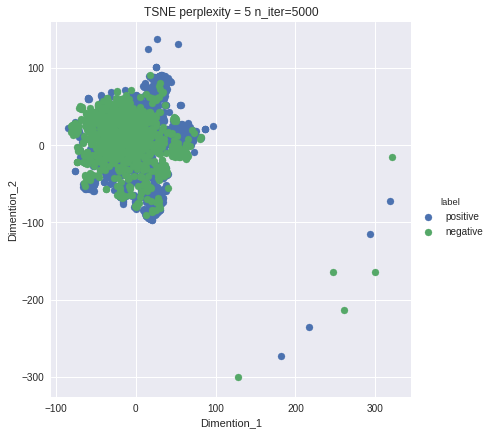

In [0]:
#BOW with perplexity = 5 and interations = 5k
model = TSNE(n_components=2, random_state=0,perplexity=5, n_iter=5000)

review_data = model.fit_transform(review_BOW)

tsne_data = np.vstack((review_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimention_1", "Dimention_2", "label"))

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dimention_1', 'Dimention_2').add_legend()
plt.title('TSNE perplexity = 5 n_iter=5000')
plt.show()

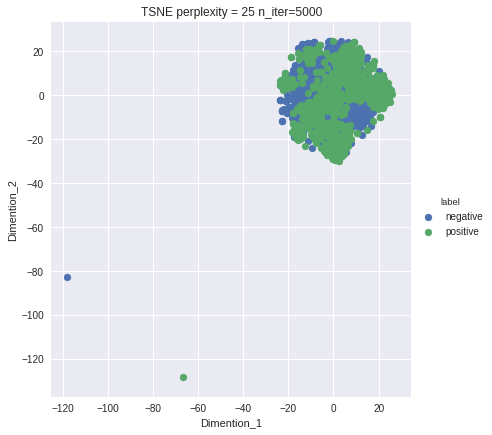

In [0]:
#BOW with perplexity = 25 and interations = 5k
model = TSNE(n_components=2, random_state=0,perplexity=25, n_iter=5000)

review_data = model.fit_transform(review_BOW)

tsne_data = np.vstack((review_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimention_1", "Dimention_2", "label"))

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dimention_1', 'Dimention_2').add_legend()
plt.title('TSNE perplexity = 25 n_iter=5000')
plt.show()

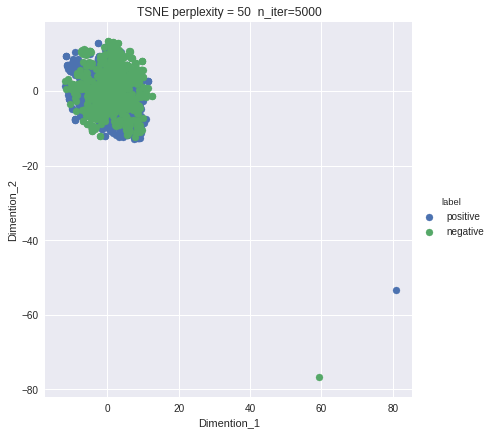

In [0]:
#BOW with perplexity = 50 and interations = 5k
model = TSNE(n_components=2, random_state=0,perplexity=50, n_iter=5000)

review_data = model.fit_transform(review_BOW)

tsne_data = np.vstack((review_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimention_1", "Dimention_2", "label"))

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dimention_1', 'Dimention_2').add_legend()
plt.title('TSNE perplexity = 50  n_iter=5000')
plt.show()

## TFIDF representation of reviews

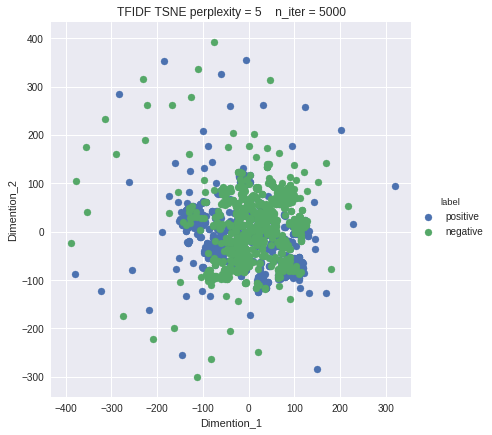

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_model = TfidfVectorizer(ngram_range=(1,2))
review_tf_idf = tf_idf_model.fit_transform(final_data['CleanedText'].values).todense() 

#tf-idf with perplexity = 5 and interations = 5k
model = TSNE(n_components=2, random_state=0,perplexity=5, n_iter=5000)

review_data = model.fit_transform(review_tf_idf)

tsne_data = np.vstack((review_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimention_1", "Dimention_2", "label"))

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dimention_1', 'Dimention_2').add_legend()
plt.title('TFIDF TSNE perplexity = 5    n_iter = 5000')
plt.show()

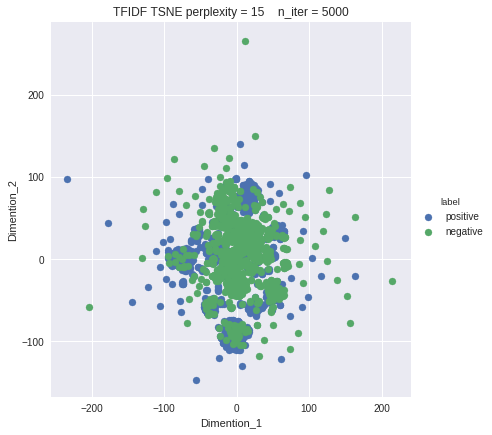

In [0]:
#tf-idf with perplexity = 15 and interations = 5k

model = TSNE(n_components=2, random_state=0,perplexity=15, n_iter=5000)

review_data = model.fit_transform(review_tf_idf)

tsne_data = np.vstack((review_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimention_1", "Dimention_2", "label"))

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dimention_1', 'Dimention_2').add_legend()
plt.title('TFIDF TSNE perplexity = 15    n_iter = 5000')
plt.show()

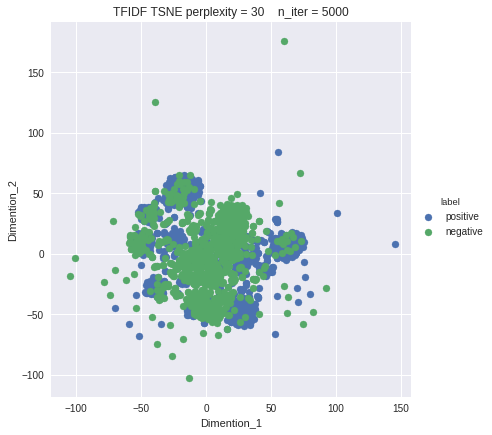

In [0]:
#tf-idf with perplexity = 30 and interations = 5k

model = TSNE(n_components=2, random_state=0,perplexity=30, n_iter=5000)

review_data = model.fit_transform(review_tf_idf)

tsne_data = np.vstack((review_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimention_1", "Dimention_2", "label"))

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dimention_1', 'Dimention_2').add_legend()
plt.title('TFIDF TSNE perplexity = 30    n_iter = 5000')
plt.show()

## AVERAGE W2V representation of reviews

In [0]:
!pip install gensim

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [0]:
list_of_sent=[]
for sent in final_data['CleanedText'].values:
    list_of_sent.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4) #min_count-word should have min this many count to be included in w2v, size- n X 50
w2v_words = list(w2v_model.wv.vocab)

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print("\n",len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 2000/2000 [00:02<00:00, 933.49it/s]


 2000
50


In [0]:
type(sent_vectors)

list

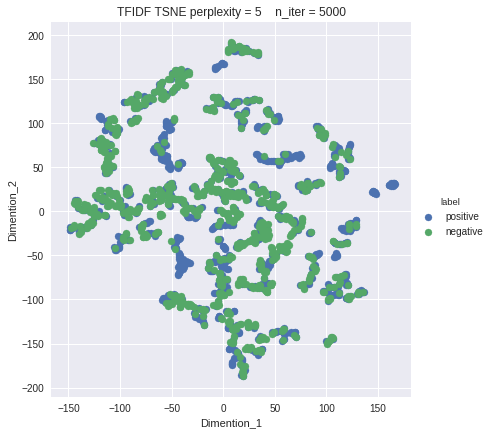

In [0]:
#Avg W2V with perplexity = 5 and interations = 5k
model = TSNE(n_components=2, random_state=0,perplexity=5, n_iter=5000)

review_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((review_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimention_1", "Dimention_2", "label"))

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dimention_1', 'Dimention_2').add_legend()
plt.title('TFIDF TSNE perplexity = 5    n_iter = 5000')
plt.show()

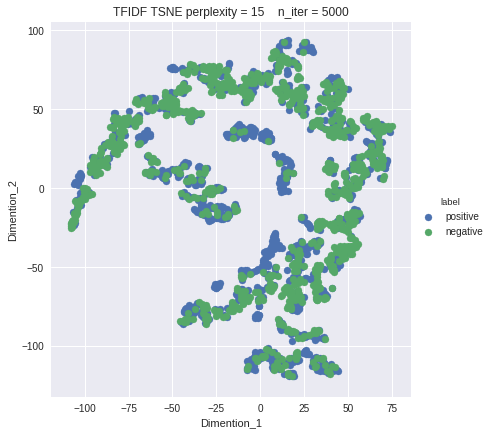

In [0]:
#Avg W2V with perplexity = 15 and interations = 5k
model = TSNE(n_components=2, random_state=0,perplexity=15, n_iter=5000)

review_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((review_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimention_1", "Dimention_2", "label"))

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dimention_1', 'Dimention_2').add_legend()
plt.title('TFIDF TSNE perplexity = 15    n_iter = 5000')
plt.show()

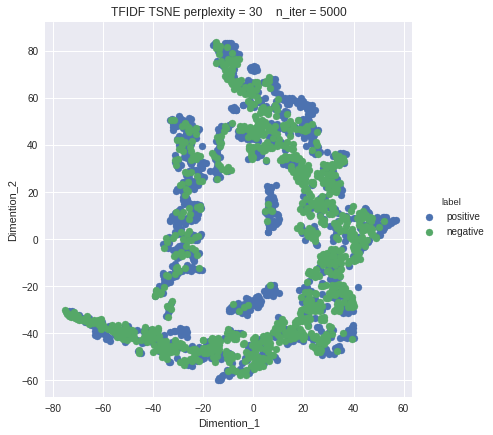

In [0]:
#Avg W2V with perplexity = 30 and interations = 5k
model = TSNE(n_components=2, random_state=0,perplexity=30, n_iter=5000)

review_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((review_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimention_1", "Dimention_2", "label"))

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dimention_1', 'Dimention_2').add_legend()
plt.title('TFIDF TSNE perplexity = 30    n_iter = 5000')
plt.show()

## TFIDF Weighted W2V

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_data['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 2000/2000 [00:02<00:00, 692.68it/s]


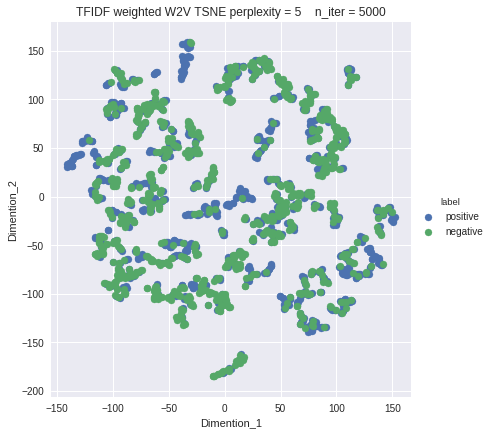

In [0]:
#tf-idf weighted W2V with perplexity = 5 and interations = 5k
model = TSNE(n_components=2, random_state=0,perplexity=5, n_iter=5000)

review_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((review_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimention_1", "Dimention_2", "label"))

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dimention_1', 'Dimention_2').add_legend()
plt.title('TFIDF weighted W2V TSNE perplexity = 5    n_iter = 5000')
plt.show()

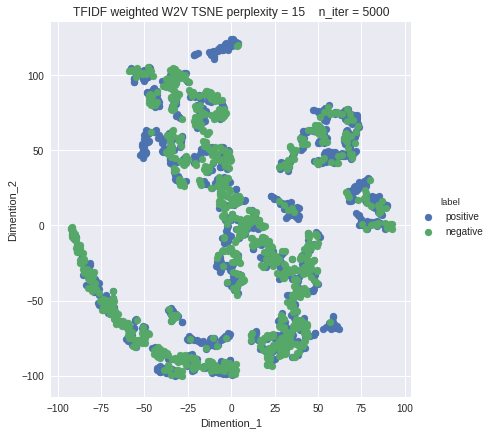

In [0]:
#tf-idf weighted W2V with perplexity = 15 and interations = 5k
model = TSNE(n_components=2, random_state=0,perplexity=15, n_iter=5000)

review_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((review_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimention_1", "Dimention_2", "label"))

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dimention_1', 'Dimention_2').add_legend()
plt.title('TFIDF weighted W2V TSNE perplexity = 15    n_iter = 5000')
plt.show()

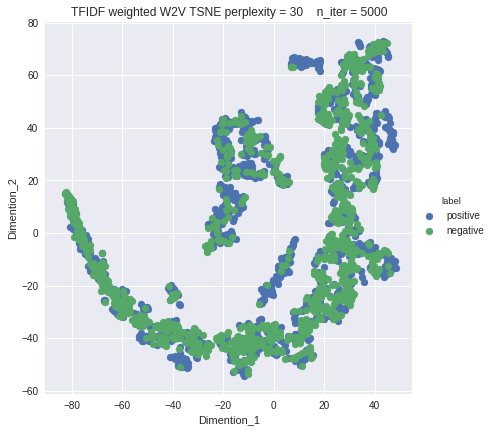

In [0]:
#tf-idf weighted W2V with perplexity = 30 and interations = 5k
model = TSNE(n_components=2, random_state=0,perplexity=30, n_iter=5000)

review_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((review_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimention_1", "Dimention_2", "label"))

sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dimention_1', 'Dimention_2').add_legend()
plt.title('TFIDF weighted W2V TSNE perplexity = 30    n_iter = 5000')
plt.show()